In [1]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def smooth_timeseries(t, size=5):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2, size // 2)], mode='edge')
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=0, arr=t)

In [216]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

In [217]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [218]:
county = 3111
z = deaths[county] 
z = z[z != 0]
init = [z[0]]
z1 = np.diff(z)
init.append(z1[0])
z2 = np.diff(z1)
print(z)

[ 1.  2.  3.  3.  4.  6.  6.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  9.  9. 10. 10.]


In [219]:
z_smooth = smooth_timeseries(z1, 9)

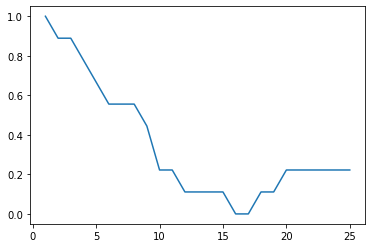

In [220]:
y = z_smooth
x = np.linspace(1, y.shape[0], y.shape[0])
plt.plot(x, y)

In [221]:
dat = z

validation_steps = 0

X_train = np.arange(dat.shape[0] - validation_steps)
y_train = dat[:dat.shape[0] - validation_steps]

X_test = np.arange(dat.shape[0] - validation_steps, dat.shape[0])
y_test = dat[dat.shape[0] - validation_steps:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(26,) (26,) (0,) (0,)


In [222]:
print(X_train, y_train)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] [ 1.  2.  3.  3.  4.  6.  6.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  9.  9. 10. 10.]


In [223]:
def erf_model(x, max_val, loc, scale):
    return max_val*(1 + scipy.special.erf(scale*(x - loc)))

def skew_model(x, max_val, loc, scale, a, shift):
    return max_val * stats.skewnorm.pdf(x, a, loc, scale) + shift

def exp_model(x, max_val, loc, scale, K, shift):
    return max_val*stats.exponnorm.pdf(x, K, loc, scale) + shift

def exp_modelcdf(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.cdf(x, K, loc, scale)

erf_bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
other_bounds = ([z.max(), 0, 0, 0], [100*z.max(), np.inf, np.inf, 10])

model = exp_modelcdf
bounds = other_bounds
popt, pcov = curve_fit(model, X_train, y_train, bounds=bounds)

In [224]:
print(popt)

[1.00000000e+01 4.58665595e-21 1.66482463e+00 4.60671566e+00]


In [225]:
errors = np.sqrt(np.diag(pcov))
print(errors)

[0.62567076 0.87428233 1.79634733 5.87748335]


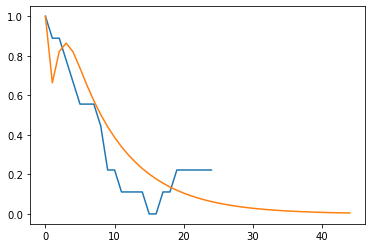

In [226]:
d = z_smooth
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)

# x = np.linspace(0, 80, 1000)
# y = exp_model(x, *popt)
x = np.linspace(0, d.shape[0] + 19, d.shape[0] + 20)
y = exp_modelcdf(x, *popt)
y0 = [z[0]]
y = np.concatenate([y0, np.diff(y)])
plt.plot(x, y)

#plt.plot(X_train, y_train, marker='o', linewidth=0)
#plt.plot(X_test, y_test, marker='o', linewidth=0)

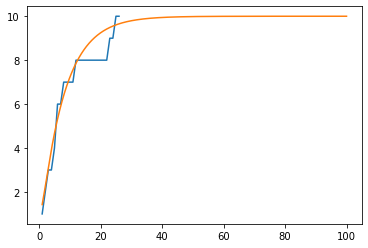

In [227]:
d = z
x = np.linspace(1, d.shape[0], d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(1, 100, 1000)
y = exp_modelcdf(x, *popt)
plt.plot(x, y)

In [848]:
d = z1
x = np.linspace(1, d.shape[0], d.shape[0])
y = model(x, *popt)

residuals = z1 - y
print(residuals)

[0.877 0.877 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123
 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123 -0.124 -0.126 -0.131 -0.144
 -0.171 -0.219 0.705 -0.400 -0.525 -0.654 0.235 1.159 -0.877 -0.875 1.154
 -0.801 2.251 0.303 -0.648]


In [195]:
import curvefit_pipeline as p
import curvefit_models as models
importlib.reload(p)
importlib.reload(models)
importlib.reload(u)

<module 'dataloader' from '..\\dataloader.py'>

In [7]:
data_format = {'name': 'deaths_raw', 'smoothing': 9, 'val_steps': 10}
model_params = {'name': 'ExpNormModel'}
horizon = 14

In [8]:
pipeline = p.Pipeline(data_format, model_params, horizon)

In [9]:
pipeline.run()

c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [11]:
use_c = pipeline.use_cumulative

In [228]:
use_c[3111]

True

In [139]:
t = 0
f = 0
for i in use_c:
    if use_c[i]:
        t += 1
    else:
        f += 1
print(t, f)

785 578


In [140]:
import pickle

with open('use_c.dat', 'wb') as handle:
    pickle.dump(use_c, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)


In [196]:
data_format = {'name': 'deaths_raw', 'smoothing': 9, 'val_steps': 0}

In [197]:
pipeline2 = p.Pipeline(data_format, model_params, horizon, use_c)
pipeline2.run()

Fitting 3142/3142


In [198]:
quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [199]:
cpredictions = pipeline2.get_combined_predictions(quantiles=quantiles, samples=250)

bruh 206 [1.40000000e+01 7.39557680e-30 1.34609682e+00 1.00000000e+01] [2.41740117e-16 3.35994038e-16 1.02120406e-15 7.92083740e-15]
bruh 262 [3.28850298e+01 7.01152972e-20 2.38130185e+00 1.00000000e+01] [1.21998213e-15 3.37611413e-16 8.20705806e-16 3.97694585e-15]
bruh 332 [5.00000000e+00 1.40325765e-20 1.38902996e+01 8.23231826e-01] [7.46063499e-16 1.19907801e-14 6.32310234e-15 1.76844488e-15]
bruh 379 [1.40000000e+01 3.79508285e-23 3.56772950e+00 2.61513895e+00] [1.78871930e-16 3.78143606e-16 6.28317340e-16 6.37521031e-16]
bruh 415 [1.33106424e+01 8.79632286e-34 3.18914463e+00 2.55238121e+00] [8.07622536e-17 2.39756156e-16 4.28823224e-16 4.48388725e-16]
bruh 428 [  2.00000867 751.15718805  43.72629846   9.9999975 ] [4.48639425e+52 1.28449257e+52 3.93700564e+50 2.10378166e+53]
bruh 462 [1.88040095e+01 9.26506495e-39 5.06578727e+00 5.18759915e+00] [8.59093226e-16 6.14402955e-16 1.02356456e-15 1.53356977e-15]
bruh 550 [6.32604305e+00 1.72930368e-15 8.31698711e+00 1.27870404e+00] [4.522

In [200]:
pred2 = pipeline2.get_combined_predictions()

[3.36029237 3.19538289 3.05581061 2.9210207  2.78332343 2.64817254
 2.51958736 2.39724879 2.28085321 2.17011179 2.07002034 1.97605889
 1.88637173 1.79700822]


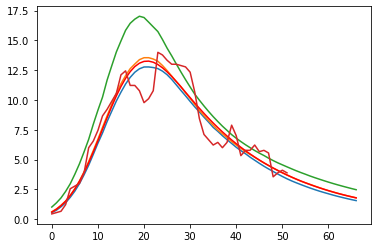

In [235]:
# 1208**, 1200, 716, 1382, 204, 1791, 1868, 1858, 2969, 1887, 1308, 1224, 1776-1794, 2289**, 2848, 3087**, 1138*, 1280, 1293**, 1870**
county = 1138
x = np.arange(0, cpredictions[county].shape[0])
y = cpredictions[county][:, 3]
plt.plot(x, y)

y = cpredictions[county][:, 4]
plt.plot(x, y)

print(cpredictions[county][:, 4][-14:])

y = cpredictions[county][:, 8]
plt.plot(x, y)

x = np.arange(0, pred2[county].shape[0])
y = pred2[county]
plt.plot(x, y, color='red')

d = pipeline2.data.daily_smoothed[county]
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)


In [120]:
z1

array([   4.,    2.,    3.,   10.,    2.,   21.,   17.,   39.,   32.,
         61.,   88.,   85.,   85.,  222.,  104.,  138.,  182.,  278.,
        188.,  305.,  387.,  218., 1013.,  524.,  562.,  579.,  513.,
        539.,  515.,  437.,  536.,  525.,  417.,    0.,    0., 1076.,
        301.,  292.,  313.,  275.,  268.,  262.,  229.,  209.,  210.,
        258.,  189.,  186.,  195.,  169.,  143.,  129.])

In [21]:
pipeline2.predict(quantiles=quantiles, samples=250)

In [56]:
import pandas as pd
df = pd.read_csv('../upstream/sample_submission.csv')
data = u.load_covid_static(days_ago=5)
data[data['FIPS'] == '08014']
len(data)

3142

In [50]:
i = df.set_index('id').sort_index().index
sub_fips = np.unique([s[11:] for s in i])
data_fips = [s.lstrip('0') for s in data['FIPS']]

In [55]:
dont_include = []
for fips in data_fips:
    if fips not in sub_fips:
        dont_include.append(fips)
dont_include

['2105', '2195', '2198', '2230', '2275', '8014', '46102']

In [58]:
must_include = []
for fips in sub_fips:
    if fips not in data_fips:
        must_include.append(fips)
must_include.remove('66010')
must_include

['2201',
 '2232',
 '2280',
 '46113',
 '51515',
 '51560',
 '72001',
 '72003',
 '72005',
 '72007',
 '72009',
 '72011',
 '72013',
 '72015',
 '72017',
 '72019',
 '72021',
 '72023',
 '72025',
 '72027',
 '72029',
 '72031',
 '72033',
 '72035',
 '72037',
 '72039',
 '72041',
 '72043',
 '72045',
 '72047',
 '72049',
 '72051',
 '72053',
 '72054',
 '72055',
 '72057',
 '72059',
 '72061',
 '72063',
 '72065',
 '72067',
 '72069',
 '72071',
 '72073',
 '72075',
 '72077',
 '72079',
 '72081',
 '72083',
 '72085',
 '72087',
 '72089',
 '72091',
 '72093',
 '72095',
 '72097',
 '72099',
 '72101',
 '72103',
 '72105',
 '72107',
 '72109',
 '72111',
 '72113',
 '72115',
 '72117',
 '72119',
 '72121',
 '72123',
 '72125',
 '72127',
 '72129',
 '72131',
 '72133',
 '72135',
 '72137',
 '72139',
 '72141',
 '72143',
 '72145',
 '72147',
 '72149',
 '72151',
 '72153',
 '78010',
 '78020',
 '78030']

In [86]:
list(pipeline2.predictions[1868][0, :])

[18.31121650428807,
 25.530274682983936,
 30.476718218132937,
 33.66332923800322,
 37.16383584517867,
 40.274649165925496,
 44.762069237891325,
 49.11515849007347,
 54.979848436804396]

In [99]:
start_date = '04/01/2020'
end_date = '06/30/2020'
prediction_start = '05/06/2020'
horizon = 14

predictions = pipeline2.predictions
data = u.load_covid_static(days_ago=5)

to_write = [['id'] + [str(q) for q in quantiles]]
for county in predictions:
    print(f'writing {county}/{len(predictions) - 1}', end='\r')
    if county == 3142:
        fips = '66010'
    else:
        fips = data.iloc[county]['FIPS'].lstrip('0')
    if fips in dont_include:
        continue
    
    county_pred = predictions[county]
    
    date = dt.datetime.strptime(start_date, '%m/%d/%Y')
    end = dt.datetime.strptime(end_date, '%m/%d/%Y')
    predict_start = dt.datetime.strptime(prediction_start, '%m/%d/%Y')
    predict_end = predict_start + dt.timedelta(days=horizon - 1)
    while date <= end:
        id_ = date.strftime('%Y-%m-%d-') + fips
        
        if predict_start <= date <= predict_end:
            index = (date - predict_start).days
            p = list(county_pred[index, :])
        else:
            p = [0 for i in range(len(quantiles))]
            
        to_write.append([id_] + p)
        date = date + dt.timedelta(days=1)

In [100]:
for fips in must_include:
    date = dt.datetime.strptime(start_date, '%m/%d/%Y')
    end = dt.datetime.strptime(end_date, '%m/%d/%Y')
    while date <= end:
        id_ = date.strftime('%Y-%m-%d-') + fips
        p = [0 for i in range(len(quantiles))]
            
        to_write.append([id_] + p)
        date = date + dt.timedelta(days=1)

In [101]:
import csv
with open("predictions.csv", "w+", newline='') as f:
        csv_writer = csv.writer(f, delimiter = ",")
        csv_writer.writerows(to_write)

In [95]:
data = u.load_covid_static(days_ago=5)

In [127]:
your_submission = pd.read_csv('predictions.csv').set_index('id').sort_index()
sample_submission = pd.read_csv('sample_submission.csv').set_index('id').sort_index()
assert(your_submission.index.equals(sample_submission.index))

print(len(your_submission.index))
print(len(sample_submission.index))

293293
293293


In [131]:
df = u.load_nyt_deaths_raw()

,Unnamed: 0,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,0,01001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,3,4,4,4,3,3,3,3,3
1,1,01003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,3,3,2,3,4,4,4,4,5
2,2,01005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,1,1,1,1,1
3,3,01007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,01009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,3138,56039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
3139,3139,56041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3140,3140,56043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3141,3141,56045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
p = dt.datetime.strptime(df.columns[-1], '%m/%d/%y')
print(p)

2020-05-05 00:00:00
